In [1]:
from datetime import datetime
print(f'Päivitetty {datetime.now().date()} / Aki Taanila')

Päivitetty 2023-03-06 / Aki Taanila


# Kolminkertainen eksponentiaalinen tasoitus

Aikasarjaennustamisessa oletan että toteutuneiden havaintojen muodostama aikasarja sisältää informaatiota, joka auttaa tulevien havaintojen ennustamisessa. 

Eksponentiaalisen tasoituksen mallit ovat erityisen suosittuja liiketaloudessa kysynnän ennustamisessa. Mallit ovat helppokäyttöisiä, nopeasti laskettavissa ja helposti päivitettävissä uusien havaintojen myötä. Ennustusmenetelmä riippuu siitä, minkälaista systemaattista vaihtelua aikasarjassa esiintyy. Eksponentiaalisia tasoitusmenetelmiä käytettäessä on kolme päävaihtoehtoa:
* **Yksinkertainen eksponentiaalinen tasoitus** aikasarjoille, joissa ei ole trendiä eikä kausivaihtelua. Jos ennustetaan pidemmälle kuin seuraavaan aikaleimaan, niin yksinkertainen eksoponentiaalinen tasoitus antaa kaikille tuleville aikaleimoille saman ennusteen.
* **Kaksinkertainen eksponentiaalinen tasoitus** eli **Holt**in menetelmä aikasarjoille, joissa on trendi, mutta ei kausivaihtelua.
* **Kolminkertainen eksponentiaalinen tasoitus** eli **Holt-Winter**in menetelmä aikasarjoille, joissa on sekä trendi että kausivaihtelu.

Tässä muistiossa käytetään **Holt-Winter**in menetelmää. Holt-Winterin tulomallissa aikasarjan tason **L** (level) hetkellä **t** määrittää lauseke

<b>L<sub>t</sub> = alfa * Y<sub>t</sub>/S<sub>t-s</sub> + (1 - alfa)(L<sub>t-1</sub> + T<sub>t-1</sub>)</b>

Yllä **Y<sub>t</sub>** on viimeisin havainto, **&nbsp;S<sub>t-s</sub>** on edellisen vastaavan periodin kausivaihtelu ja **&nbsp; T<sub>t-1</sub>** on edellinen trendi.

Trendille **T** hetkellä **t** saadaan arvio lausekkeesta

<b>T<sub>t </sub>= beta * (L<sub>t</sub> - L<sub>t-1</sub>) + (1 - beta) * T<sub>t-1</sub></b>

Kausivaihtelulle **S** hetkellä **t** saadaan arvio lausekkeesta
<b>S<sub>t</sub> = gamma * Y<sub>t</sub>/L<sub>t</sub> + (1 - gamma) * S<sub>t-s</sub></b>

Ennuste hetkelle **t + p** saadaan
<b>(L<sub>t</sub> + pT<sub>t</sub>)S<sub>t-s</sub></b>

Yllä on kyse Holt-Winterin tulomallista, jossa kausivaihtelu huomioidaan kausivaihtelukertoimena. Holt-Winterin mallia voidaan soveltaa myös summamallina, jolloin kausivaihtelu huomioidaan lisättävänä kausivaihteluterminä. Tulomalli soveltuu paremmin tilanteisiin, joissa kausivaihtelukomponentin suuruus vaihtelee aikasarjan tason **L** mukaan. Summamalli soveltuu tilanteisiin, joissa kausivaihtelukomponentin suuruus ei riipu aikasarjan tasosta **L**.

Mallin parametrit **alfa**, **beta** ja **gamma** pyritään määrittämään siten että ennustevirheiden neliöiden summa saadaan mahdollisimman pieneksi.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.api import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing

sns.set_style('whitegrid')

## Aikasarjaan tutustuminen

In [3]:
df = pd.read_excel('http://taanila.fi/aikasarja.xlsx')
df.head()

,Vuosineljännes,Kysyntä
0,2013-12-31,500
1,2014-03-31,350
2,2014-06-30,250
3,2014-09-30,400
4,2014-12-31,450


In [4]:
# Aikaleimat indeksiin
# to_datetime muuntaa merkkijonomuotoisen tiedon aikaleimoiksi
# format mahdollistaa erilaisten esitysmuotojen tunnistamisen aikaleimoiksi
df.index = pd.to_datetime(df['Vuosineljännes'], format="%Y-%m-%d")

# Pudotetaan tarpeettomaksi käynyt sarake pois
df = df.drop('Vuosineljännes', axis=1)
df

,Kysyntä
Vuosineljännes,
2013-12-31,500
2014-03-31,350
2014-06-30,250
2014-09-30,400
2014-12-31,450
2015-03-31,350
2015-06-30,200
2015-09-30,300
2015-12-31,350


<AxesSubplot: xlabel='Vuosineljännes'>

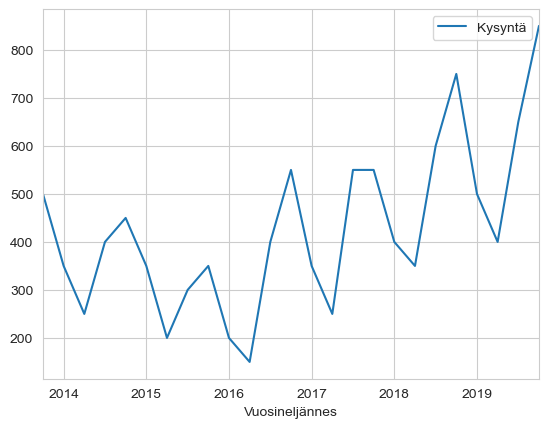

In [5]:
df.plot()

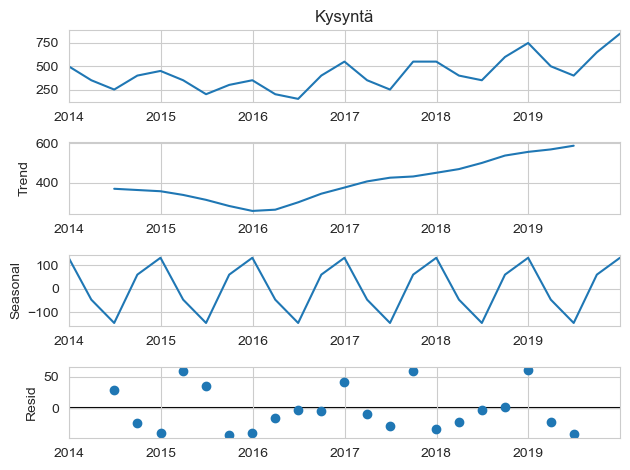

In [6]:
# Aikasarjan vaihtelua aiheuttavien komponenttien erottelu
# Observed=alkuperäinen aikasarja, Trend=trendi, Seasonal=kausivaihtelu,
# Residual=muu kuin trendiin ja kausivaihteluun liittyvä vaihtelu

decompose = seasonal_decompose(df['Kysyntä']).plot()

Tässä aikasarjassa on selvästi havaittavat trendi ja kausivaihtelu. Koska kyse on vuosineljänneksittäisestä datasta, niin kausivaihtelu esiintyy neljän havainnon (vuosineljänneksen) jaksoissa.

## Mallin sovitus

Ennustemalli sovitetaan (**fit**) dataan.
Tuloksena saadaan olio (tässä olen antanut oliolle nimeksi **malli**), joka sisältää monenlaista tietoa mallista.

Trendiin (**trend**) käytän summamallia (**add**), jossa trendi on aikasarjaan lisättävä termi. Tämä on suositeltavin vaihtoehto.

Kausivaihteluun (**seasonal**) käytän summamallia (**add**) tai tulomallia (**mul**). Tulomallissa kausivaihtelu ilmenee kertoimina. Tässä olen kokeillut myös summamallia, mutta tulomalli osoittautui paremmaksi.

**seasonal_periods**-parametrille käytän arvoa 4, koska kausivaihtelu esiintyy neljän vuosineljänneksen jaksoissa.

**freq**-parametrille käytän arvoa **'Q'**, koska kyseessä ovat vuosineljänneksien viimeiset päivät. Lisätietoa <b>freq</b>-parametrin mahdollisista arvoista https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases

In [7]:
malli = ExponentialSmoothing(df['Kysyntä'], trend='add', seasonal='mul', 
                             seasonal_periods=4, freq='Q').fit()

In [8]:
# malli-olion avulla saan mallin mukaan simuloidut ennusteet (fittedvalues) jo toteutuneille ajankohdille
df['Ennuste'] = malli.fittedvalues
df

,Kysyntä,Ennuste
Vuosineljännes,,
2013-12-31,500,500.361288
2014-03-31,350,343.996373
2014-06-30,250,265.222508
2014-09-30,400,445.316005
2014-12-31,450,496.221285
2015-03-31,350,313.025004
2015-06-30,200,262.293162
2015-09-30,300,366.159531
2015-12-31,350,377.900949


<AxesSubplot: xlabel='Vuosineljännes'>

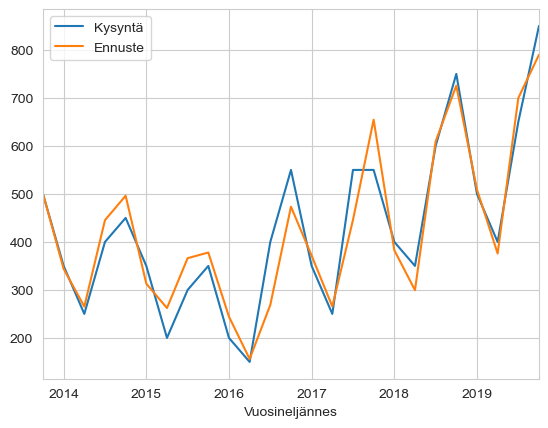

In [9]:
# Alkuperäinen aikasarja ja mallin mukaiset ennusteet samaan kaavioon
df.plot()

In [10]:
# Ennustevirheet (residuaalit) löytyvät malli-oliosta
df['Ennustevirhe'] = malli.resid
df

,Kysyntä,Ennuste,Ennustevirhe
Vuosineljännes,,,
2013-12-31,500,500.361288,-0.361288
2014-03-31,350,343.996373,6.003627
2014-06-30,250,265.222508,-15.222508
2014-09-30,400,445.316005,-45.316005
2014-12-31,450,496.221285,-46.221285
2015-03-31,350,313.025004,36.974996
2015-06-30,200,262.293162,-62.293162
2015-09-30,300,366.159531,-66.159531
2015-12-31,350,377.900949,-27.900949


## Mallin tarkastelu

Mallin hyvyyden tarkasteluun on monia tapoja. Tässä käytän

* ennustevirheiden aikasarjaa viivakaaviona
* ennusteiden ja toteutuneiden arvojen hajontakaaviota
* malliin liittyvää statistiikkaa, jonka saan **summary**-funktiolla.

Huomaa erityisesti **SSE** (sum of squared errors). Mallia laskeva algoritmi yrittää saada SSE:n mahdollisimman pieneksi.

Text(0, 0.5, 'Ennustevirhe')

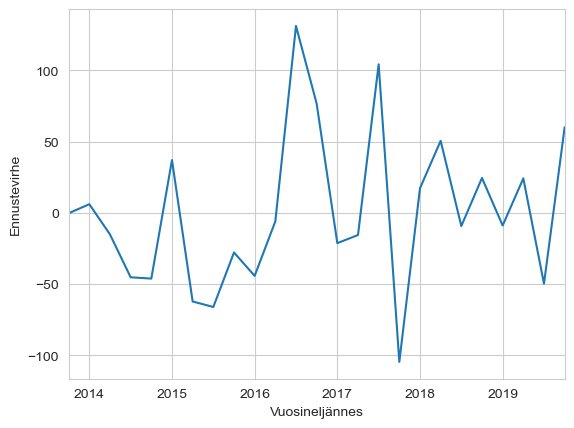

In [11]:
# Ennustevirheet aikasarjana
# On hyvä, jos ennustevirheiden aikasarjan vaihtelu on sattumanvaraista
df['Ennustevirhe'].plot()
plt.ylabel('Ennustevirhe')

Text(0, 0.5, 'Toteutunut kysyntä')

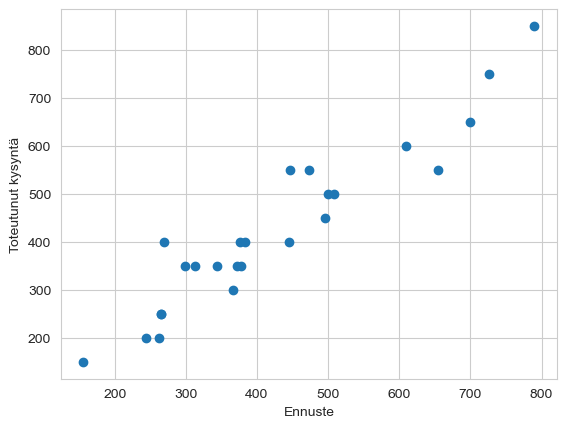

In [12]:
# Ennusteiden ja toteutuneiden kysyntöjen hajontakaavio
# Ennustemalli on sitä parempi, mitä paremmin pisteet seuraavat suoraa viivaa
# vasemmasta alakulmasta oikeaan yläkulmaan
plt.scatter(x = df['Ennuste'], y = df['Kysyntä'])
plt.xlabel('Ennuste')
plt.ylabel('Toteutunut kysyntä')

In [13]:
# Mallin statistiikkaa
malli.summary()

Dep. Variable:,Kysyntä,No. Observations:,25
Model:,ExponentialSmoothing,SSE,72742.406
Optimized:,True,AIC,215.395
Trend:,Additive,BIC,225.146
Seasonal:,Multiplicative,AICC,231.109
Seasonal Periods:,4,Date:,"Mon, 06 Mar 2023"
Box-Cox:,False,Time:,17:25:38
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.8965013,alpha,True
smoothing_trend,0.0119557,beta,True


## Ennusteiden laskeminen

Ennustettavien ajankohtien aikaleimojen määrittämiseksi:

* Ensimmäisen ennustettavan ajankohdan aikaleiman täytyy olla aikasarjan viimeisintä aikaleimaa seuraava aikaleima.
* Ennustettavien ajankohtien lukumäärän voin määrittää **periods**-parametrilla.
* Ennustettavien ajankohtien frekvenssin on oltava sama kuin mallia sovitettaessa käytetty **freq**-parametrin arvo.
        
Lisätietoa **freq**-parametrin mahdollisista arvoista https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases

In [14]:
#Tarkistan viimeisen aikaleiman
df.tail()

,Kysyntä,Ennuste,Ennustevirhe
Vuosineljännes,,,
2018-12-31,750,725.597453,24.402547
2019-03-31,500,508.968588,-8.968588
2019-06-30,400,375.853080,24.146920
2019-09-30,650,699.824318,-49.824318
2019-12-31,850,789.985348,60.014652


In [15]:
# Ennustettavien ajankohtien aikaleimat (alkupäivänä aikasarjan viimeistä aikaleimaa seuraava aikaleima)
index = pd.date_range('2020-03-31', periods=8, freq='Q')

# Ennusteet kahdeksalle vuosineljännekselle
ennusteet = malli.forecast(8)

# Ennusteet dataframeen
df_ennuste = pd.DataFrame(data=ennusteet, index=index, columns=['Ennuste'])
df_ennuste

,Ennuste
2020-03-31,573.205675
2020-06-30,429.554427
2020-09-30,754.271537
2020-12-31,908.356987
2021-03-31,616.245179
2021-06-30,461.213502
2021-09-30,808.857186
2021-12-31,972.925416


<AxesSubplot: xlabel='Vuosineljännes'>

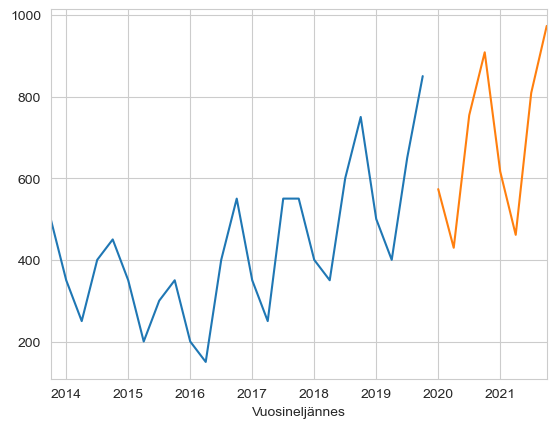

In [16]:
# Viivakaavio havainnoista
df['Kysyntä'].plot()

# Ennusteet kaavioon
df_ennuste['Ennuste'].plot()

In [17]:
# Tietokehikko, jossa alkuperäinen aikasarja ja lasketut ennusteet
df1 = pd.concat([df, df_ennuste])
df1

,Kysyntä,Ennuste,Ennustevirhe
2013-12-31,500.0,500.361288,-0.361288
2014-03-31,350.0,343.996373,6.003627
2014-06-30,250.0,265.222508,-15.222508
2014-09-30,400.0,445.316005,-45.316005
2014-12-31,450.0,496.221285,-46.221285
2015-03-31,350.0,313.025004,36.974996
2015-06-30,200.0,262.293162,-62.293162
2015-09-30,300.0,366.159531,-66.159531
2015-12-31,350.0,377.900949,-27.900949
2016-03-31,200.0,244.302321,-44.302321


<h2>Lisätietoa</h2>

Data-analytiikka Pythonilla: https://tilastoapu.wordpress.com/python/